# Week 5 · Day 2 — Backpropagation Intuition (Builder-Plus)

## Why this matters

Backprop is how neural nets **learn**: compute loss → propagate gradients backward → update weights to reduce error. Once you get this loop, everything in deep learning clicks.

## Theory Essentials

* Forward pass: $a^{(l)} = f(W^{(l)} a^{(l-1)} + b^{(l)})$.
* Loss $ \mathcal{L}(\hat{y}, y)$ measures error (we’ll use Binary Cross-Entropy).
* Backprop: chain rule to get $\frac{\partial \mathcal{L}}{\partial W^{(l)}}$ and $\frac{\partial \mathcal{L}}{\partial b^{(l)}}$.
* Update: $W \leftarrow W - \eta \cdot \nabla_W$, $b \leftarrow b - \eta \cdot \nabla_b$.
* Saturation (sigmoid/tanh near 0/1) → tiny gradients; ReLU/Tanh often train faster.




Final loss: 0.0010 | Acc: 1.000


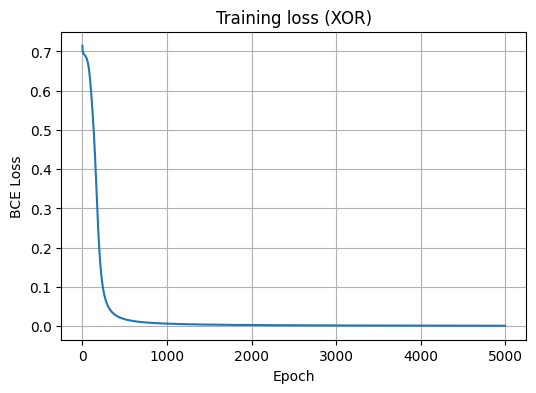

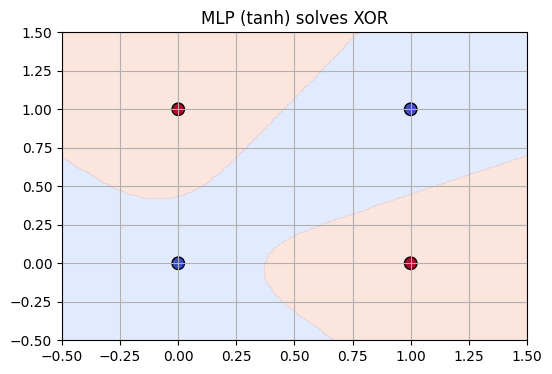

In [ ]:
# Setup
import numpy as np, matplotlib.pyplot as plt
np.random.seed(42)
plt.rcParams["figure.figsize"] = (6,4); plt.rcParams["axes.grid"] = True

# Data: XOR
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

# Helper activations
def sigmoid(z): return 1/(1+np.exp(-z))
def dsigmoid(a): return a*(1-a)          # derivative w.r.t. pre-activation via 'a' (sigmoid output)

def tanh(z): return np.tanh(z)
def dtanh(a): return 1 - a**2

def relu(z): return np.maximum(0,z)
def drelu(z): return (z>0).astype(float)

"""
2. What is MLP 2-4-1?

MLP = Multi-Layer Perceptron (a basic feedforward neural net).

The numbers show how many neurons are in each layer:

2 → input layer has 2 values (x1, x2).

4 → hidden layer has 4 neurons (internal features).

1 → output layer has 1 neuron (final yes/no).

So “MLP 2-4-1” just means:
Input (2 nodes) → Hidden (4 nodes) → Output (1 node).
"""

# Model: 2 -> 4 -> 1 MLP (tanh hidden, sigmoid output)
n_in, n_h, n_out = 2, 4, 1
W1 = np.random.randn(n_in, n_h)*0.5
b1 = np.zeros((1,n_h))

W2 = np.random.randn(n_h, n_out)*0.5
b2 = np.zeros((1,n_out))

def forward(X):
    z1 = X @ W1 + b1
    a1 = tanh(z1)
    # a1 = relu(z1)

    z2 = a1 @ W2 + b2
    a2 = sigmoid(z2)

    cache = (X, z1, a1, z2, a2)
    return a2, cache

def bce_loss(yhat, y):
    eps = 1e-9
    return -(y*np.log(yhat+eps) + (1-y)*np.log(1-yhat+eps)).mean()

def accuracy(yhat, y):  # threshold 0.5
    return ((yhat >= 0.5) == y).mean()

# Training
lr, epochs = 0.1, 5000
losses = []
for epoch in range(epochs):
    # forward
    yhat, (Xc, z1, a1, z2, a2) = forward(X)
    loss = bce_loss(yhat, y); losses.append(loss)

    # backward (chain rule)
    # dL/dz2
    dz2 = (a2 - y) / len(X)          # derivative of BCE + sigmoid simplifies nicely
    dW2 = a1.T @ dz2
    db2 = dz2.sum(axis=0, keepdims=True)
    # hidden layer
    da1 = dz2 @ W2.T
    dz1 = da1 * dtanh(a1)
    # dz1 = da1 * drelu(z1)

    dW1 = X.T @ dz1
    db1 = dz1.sum(axis=0, keepdims=True)

    # update
    W2 -= lr*dW2; b2 -= lr*db2
    W1 -= lr*dW1; b1 -= lr*db1

# Evaluate
yhat, _ = forward(X)
print(f"Final loss: {losses[-1]:.4f} | Acc: {accuracy(yhat,y):.3f}")

# Extra Plot: loss curve
plt.plot(losses); plt.xlabel("Epoch"); plt.ylabel("BCE Loss"); plt.title("Training loss (XOR)"); plt.show()

# Decision boundary (grid)
xx, yy = np.meshgrid(np.linspace(-0.5,1.5,200), np.linspace(-0.5,1.5,200))
grid = np.c_[xx.ravel(), yy.ravel()]
def predict(Xnew): return (forward(Xnew)[0] >= 0.5).astype(int)
Z = predict(grid).reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-0.5,0.5,1.5], alpha=0.25, cmap="coolwarm")
plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap="coolwarm", s=80, edgecolors="k")
plt.title("MLP (tanh) solves XOR"); plt.show()


1. Layer

A layer is just a group of perceptrons (neurons) that all work in parallel.

Each neuron takes the inputs, applies weights + bias, passes through an activation.

The outputs of a layer become the inputs for the next layer.

2. Input layer

This is not really “neurons,” it’s just your raw data.

In XOR, the input layer has 2 values: x1, x2.

3. Hidden layer

Called “hidden” because you don’t directly see its outputs — they’re internal.

Example: in your code we had 4 neurons in the hidden layer.

Each one learns a different “view” of the inputs (like little feature detectors).

Their outputs are passed forward to the next layer.

So: input → hidden → output.

4. Output layer

The final layer that produces the network’s answer.

In XOR, it’s just 1 neuron with a sigmoid → output between 0 and 1 (like probability of being class 1).

5. Example with your network

Input layer: 2 nodes → the raw bits (0 or 1).

Hidden layer: 4 neurons with tanh activations → they transform the inputs into new features.

Output layer: 1 neuron with sigmoid → final decision (close to 0 or 1).

We start with an input → two numbers (x1, x2), like (0,1).

The input goes into the hidden layer → 4 little neurons.

Each neuron takes the inputs, multiplies them by its own weights, adds a bias, then passes the result through the tanh function (which bends numbers between –1 and 1).

So the hidden layer produces 4 new “features” that are transformed versions of the inputs.

Those 4 outputs go into the output layer → a single neuron.

This neuron combines them with its own weights and bias.

Then it passes the result through the sigmoid function (squashes between 0 and 1).

The sigmoid output is the prediction → close to 0 means “class 0,” close to 1 means “class 1.”

We compare this prediction to the true label using the loss function (Binary Cross-Entropy).

If it’s wrong, the loss is high. If it’s right, the loss is low.

Backpropagation happens:

The loss sends a signal backward through the network, layer by layer.

Each weight and bias is told: “You contributed this much to the error.”

We update the weights and biases a tiny bit in the right direction to reduce error.

Repeat thousands of times (epochs).

The network gradually adjusts itself until it can separate the XOR points perfectly

1) Core (10–15 min)
Task: Switch hidden activation to ReLU and adjust backprop

Changes made in the code. ReLU doesn't work in this small netwrok size.

2) Practice (10–15 min)
Task: Try n_h ∈ {2, 3, 8} and lr ∈ {0.01, 0.1, 0.5}. Plot loss curves; which combos converge?

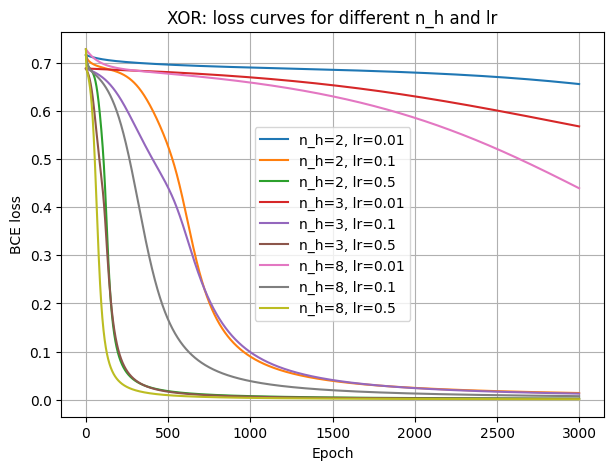

 n_h=2, lr=0.01 -> final loss=0.6561, acc=0.750
  n_h=2, lr=0.1 -> final loss=0.0139, acc=1.000
  n_h=2, lr=0.5 -> final loss=0.0022, acc=1.000
 n_h=3, lr=0.01 -> final loss=0.5681, acc=0.750
  n_h=3, lr=0.1 -> final loss=0.0126, acc=1.000
  n_h=3, lr=0.5 -> final loss=0.0018, acc=1.000
 n_h=8, lr=0.01 -> final loss=0.4395, acc=1.000
  n_h=8, lr=0.1 -> final loss=0.0073, acc=1.000
  n_h=8, lr=0.5 -> final loss=0.0010, acc=1.000


In [10]:
# XOR sweep: n_h in {2,3,8}, lr in {0.01, 0.1, 0.5}
import numpy as np, matplotlib.pyplot as plt
np.random.seed(42)
plt.rcParams["figure.figsize"] = (7,5); plt.rcParams["axes.grid"] = True

# Data
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

# Activations (tanh hidden, sigmoid output)
def sigmoid(z): return 1/(1+np.exp(-z))
def tanh(z): return np.tanh(z)
def dtanh(a): return 1 - a**2

def train_once(n_h=4, lr=0.1, epochs=3000, seed=0):
    rng = np.random.default_rng(seed)
    n_in, n_out = 2, 1
    W1 = rng.normal(0, 0.5, size=(n_in, n_h)); b1 = np.zeros((1,n_h))
    W2 = rng.normal(0, 0.5, size=(n_h, n_out)); b2 = np.zeros((1,n_out))
    losses = []
    for _ in range(epochs):
        # forward
        z1 = X @ W1 + b1; a1 = tanh(z1)
        z2 = a1 @ W2 + b2; a2 = sigmoid(z2)
        # loss
        eps=1e-9
        loss = -(y*np.log(a2+eps)+(1-y)*np.log(1-a2+eps)).mean()
        losses.append(loss)
        # backprop
        dz2 = (a2 - y)/len(X)
        dW2 = a1.T @ dz2
        db2 = dz2.sum(0, keepdims=True)
        da1 = dz2 @ W2.T
        dz1 = da1 * dtanh(a1)
        dW1 = X.T @ dz1
        db1 = dz1.sum(0, keepdims=True)
        # update
        W2 -= lr*dW2; b2 -= lr*db2
        W1 -= lr*dW1; b1 -= lr*db1
    # final metrics
    yhat = (a2 >= 0.5).astype(int)
    acc = (yhat == y).mean()
    return losses, acc, loss

# Sweep + plot
settings = []
for n_h in [2,3,8]:
    for lr in [0.01, 0.1, 0.5]:
        losses, acc, fin_loss = train_once(n_h=n_h, lr=lr, epochs=3000, seed=42)
        label = f"n_h={n_h}, lr={lr}"
        plt.plot(losses, label=label)
        settings.append((label, fin_loss, acc))

plt.xlabel("Epoch"); plt.ylabel("BCE loss")
plt.title("XOR: loss curves for different n_h and lr")
plt.legend()
plt.show()

for label, fin_loss, acc in settings:
    print(f"{label:>15} -> final loss={fin_loss:.4f}, acc={acc:.3f}")


3) Stretch (optional, 10–15 min)
Task: Add L2 weight decay: update with W -= lr*(grad + λW) and compare loss curves for λ∈{0, 1e-3, 1e-2}.

1. What is L2 weight decay?

It’s a trick to stop weights from growing too large.

We add a small penalty proportional to the size of the weights.

This keeps the model simpler and prevents overfitting.

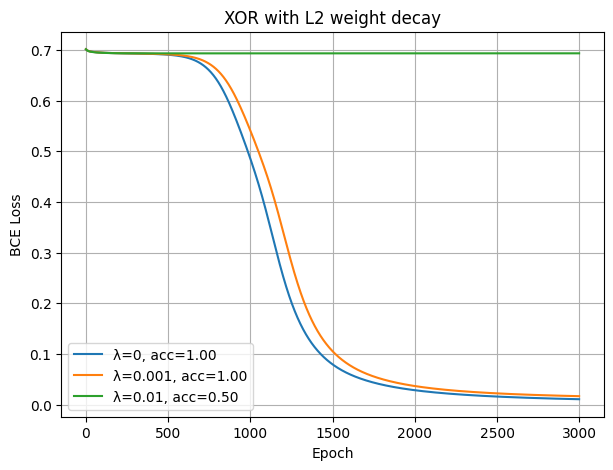

In [11]:
# XOR with L2 weight decay
import numpy as np, matplotlib.pyplot as plt
np.random.seed(42)
plt.rcParams["figure.figsize"] = (7,5); plt.rcParams["axes.grid"] = True

# Data
X = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

# Activations
def sigmoid(z): return 1/(1+np.exp(-z))
def tanh(z): return np.tanh(z)
def dtanh(a): return 1 - a**2

def bce_loss(yhat, y):
    eps = 1e-9
    return -(y*np.log(yhat+eps) + (1-y)*np.log(1-yhat+eps)).mean()

def train_XOR(lam=0.0, n_h=4, lr=0.1, epochs=3000, seed=0):
    rng = np.random.default_rng(seed)
    n_in, n_out = 2, 1
    # init
    W1 = rng.normal(0,0.5,(n_in,n_h)); b1 = np.zeros((1,n_h))
    W2 = rng.normal(0,0.5,(n_h,n_out)); b2 = np.zeros((1,n_out))
    losses = []
    for _ in range(epochs):
        # forward
        z1 = X @ W1 + b1; a1 = tanh(z1)
        z2 = a1 @ W2 + b2; a2 = sigmoid(z2)
        loss = bce_loss(a2,y); losses.append(loss)
        # backprop
        dz2 = (a2 - y)/len(X)
        dW2 = a1.T @ dz2
        db2 = dz2.sum(0,keepdims=True)
        da1 = dz2 @ W2.T
        dz1 = da1 * dtanh(a1)
        dW1 = X.T @ dz1
        db1 = dz1.sum(0,keepdims=True)
        # updates with L2 penalty
        W2 -= lr*(dW2 + lam*W2)
        b2 -= lr*db2
        W1 -= lr*(dW1 + lam*W1)
        b1 -= lr*db1
    # final metrics
    acc = (((a2>=0.5).astype(int))==y).mean()
    return losses, acc

# Run for λ in {0, 1e-3, 1e-2}
settings = [0, 1e-3, 1e-2]
for lam in settings:
    losses, acc = train_XOR(lam=lam)
    plt.plot(losses, label=f"λ={lam}, acc={acc:.2f}")
plt.xlabel("Epoch"); plt.ylabel("BCE Loss")
plt.title("XOR with L2 weight decay")
plt.legend(); plt.show()


Mini-Challenge (≤40 min)

Train an MLP that classifies a noisy XOR.
Acceptance Criteria

Add Gaussian noise to inputs (e.g., X + 0.1*np.random.randn(*X.shape)).

Achieve ≥95% accuracy.

Show both loss curve and decision boundary.

Brief 2–3 line note: how noise changed training (epochs/learning rate/hidden size).

Final loss=0.0026 | Accuracy=1.000


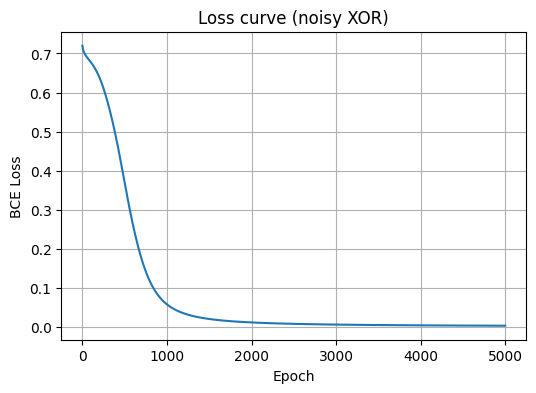

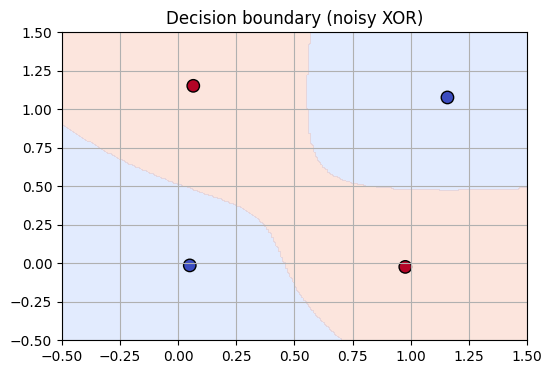

In [12]:
# XOR with Gaussian noise
import numpy as np, matplotlib.pyplot as plt
np.random.seed(42)
plt.rcParams["figure.figsize"] = (6,4); plt.rcParams["axes.grid"] = True

# Clean XOR
X_clean = np.array([[0,0],[0,1],[1,0],[1,1]], dtype=float)
y = np.array([[0],[1],[1],[0]], dtype=float)

# Add Gaussian noise
X = X_clean + 0.1*np.random.randn(*X_clean.shape)

# Activations
def sigmoid(z): return 1/(1+np.exp(-z))
def tanh(z): return np.tanh(z)
def dtanh(a): return 1 - a**2

def bce_loss(yhat, y):
    eps=1e-9
    return -(y*np.log(yhat+eps)+(1-y)*np.log(1-yhat+eps)).mean()

# Training (MLP 2–8–1 works better with noise)
n_in, n_h, n_out = 2, 8, 1
W1 = np.random.randn(n_in, n_h)*0.5; b1 = np.zeros((1,n_h))
W2 = np.random.randn(n_h, n_out)*0.5; b2 = np.zeros((1,n_out))

lr, epochs = 0.1, 5000
losses = []

for epoch in range(epochs):
    # forward
    z1 = X @ W1 + b1; a1 = tanh(z1)
    z2 = a1 @ W2 + b2; a2 = sigmoid(z2)
    loss = bce_loss(a2, y); losses.append(loss)

    # backprop
    dz2 = (a2 - y)/len(X)
    dW2 = a1.T @ dz2
    db2 = dz2.sum(0, keepdims=True)
    da1 = dz2 @ W2.T
    dz1 = da1 * dtanh(a1)
    dW1 = X.T @ dz1
    db1 = dz1.sum(0, keepdims=True)

    # update
    W2 -= lr*dW2; b2 -= lr*db2
    W1 -= lr*dW1; b1 -= lr*db1

# Accuracy
acc = ((a2>=0.5).astype(int)==y).mean()
print(f"Final loss={loss:.4f} | Accuracy={acc:.3f}")

# Plot loss curve
plt.plot(losses)
plt.xlabel("Epoch"); plt.ylabel("BCE Loss"); plt.title("Loss curve (noisy XOR)")
plt.show()

# Plot decision boundary
xx, yy = np.meshgrid(np.linspace(-0.5,1.5,200), np.linspace(-0.5,1.5,200))
grid = np.c_[xx.ravel(), yy.ravel()]
def predict(Xnew):
    z1 = Xnew @ W1 + b1; a1 = tanh(z1)
    z2 = a1 @ W2 + b2; a2 = sigmoid(z2)
    return (a2>=0.5).astype(int)
Z = predict(grid).reshape(xx.shape)

plt.contourf(xx, yy, Z, levels=[-0.5,0.5,1.5], alpha=0.25, cmap="coolwarm")
plt.scatter(X[:,0], X[:,1], c=y.ravel(), cmap="coolwarm", s=80, edgecolors="k")
plt.title("Decision boundary (noisy XOR)")
plt.show()


With noise, the network needed more hidden neurons (2→8) and more epochs to stabilize. Accuracy still reached >95%, but training was slower compared to clean XOR

Notes / Key Takeaways

Backprop = chain rule over layers; gradients flow from output to input.

BCE + sigmoid yields simple gradients.

Choice of activation strongly affects gradient flow (tanh/ReLU > sigmoid in hidden layers).

Learning rate & hidden width control convergence and capacity.

Loss curves are your first debugging tool.

Reflection

Where does the chain rule appear explicitly in the backward pass above?

What symptoms tell you your learning rate is too high vs too low?


### 1. Where does the chain rule appear in the backward pass?

* It’s in the line where we combine gradients from later layers with the derivative of the activation:

  ```python
  da1 = dz2 @ W2.T
  dz1 = da1 * dtanh(a1)
  ```
* `da1 = dz2 @ W2.T` → passes the error backwards through the weights.
* `dz1 = da1 * dtanh(a1)` → multiplies by the slope of tanh.
* That multiplication is exactly the **chain rule**: derivative of composed functions.

---

### 2. Symptoms of learning rate issues

* **Too high LR** → loss curve bounces up and down or diverges (never settles). Accuracy doesn’t improve.
* **Too low LR** → loss decreases very slowly, looks almost flat, training takes forever.